# State of the Art Technology - Prototype 1

In [2]:
#Imports
import cv2
import math
import numpy as np

In [3]:
#Create vehicle tracker
class EuclideanDistTracker:
    def __init__(self):
        self.center_points = {} # Creates a space for the center positions of detections and stores IDs
        self.id_count = 0 #As new objects are detected this will increase

    def update(self, objects_rect):
        objects_bbs_ids = []
        
        for rect in objects_rect: #Gets the centre point for new objects detected
            x, y, w, h = rect
            cx = (x + x + w) // 2 #Xmid
            cy = (y + y + h) // 2 #Ymid

            # Determine if the object is new or previously detected
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 100: # Set the distance for new obj to be created.
                    self.center_points[id] = (cx, cy)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break

            # In scenario of new object, new ID is created
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1 #ID +1

        # Resets the dictionary removing unused IDs
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids


In [28]:
# Video import
cap = cv2.VideoCapture('/Users/raffaelenardi/Documents/GITHUB/State of the Art Technology/INPUT_FINAL_V1.mp4')

# Create tracker object
tracker = EuclideanDistTracker()

#Create lists for later
car_count = []
car_count_clean = []


# Object detection from stable uncalibrated camera, using a KNN mask to separate foreground and background
object_detector = cv2.createBackgroundSubtractorKNN(history=1000, dist2Threshold=4500, detectShadows = False)

# Begin reading video frames
while(cap.isOpened()):
    ret, frame = cap.read() 
    height, width, _ = frame.shape        
    frame = cv2.resize(frame, (1280, 720))
    
    # Extract Region of interest for this analysis
    roi = frame[225: 600,350: 750] 
    
    # Detect objects within the KNN mask using thresholds
    mask = object_detector.apply(roi)
    _, mask = cv2.threshold(mask, 254, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []
    
    for cnt in contours: # individual contour analysis to determin if bbox is needed
        area = cv2.contourArea(cnt) # Calculate area and remove small elements
        if area > 5000 and area < 50000: 
            x, y, w, h = cv2.boundingRect(cnt) #bboxs created
            xMid = int((x + (x+w))/2) #Finds mid values for bboxs
            yMid = int((y + (y+h))/2)
            cv2.circle(roi, (xMid,yMid),5,(0,0,255),10) #adds circle at xmid x ymid
            detections.append([x, y, w, h]) #appends these detections to list created previously
            
    # Tracking objects using ID
    boxes_ids = tracker.update(detections)
    for box_id in boxes_ids:
        x, y, w, h, id = box_id
        
        #Create car counter for ROI
        if yMid > 125 and yMid < 130 and xMid > 110 and xMid < 350: #counts as object mid point moves through detection area
            car_count.append(id) #adds ID to list for counting
            car_count_clean = list(dict.fromkeys(car_count)) #removes duplicates of same ID

        cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 3) #Shows bounding box for veh. only within ROI
            
         #Debugging tests
        cv2.putText(roi, "ID: " + str(id), (x + 10, y + 30), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2) #Shows ID
#       cv2.putText(roi, 'YMid : {}'.format(yMid), (x, y-20), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2) #YMID
#       cv2.putText(roi, 'XMid : {}'.format(xMid), (x, y-50), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2) #XMID
#       cv2.putText(roi, 'w : {}'.format(w), (x-150, y-20), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2) #BBOX width
#       cv2.putText(roi, 'h : {}'.format(h), (x-150, y-50), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2) #BBOX height
#        cv2.rectangle(roi,(110,125),(350,130),(255,0,0),2) # Shows deteciton area for counting
  
    # Graphical display of analysis
#    cv2.line(roi,(110,155),(350,125),(0,0,255),2) # Red line to denote area count occurs
#    cv2.putText(frame, 'Total cars across the line : {}'.format(len(car_count_clean)), (360, 590), cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,255), 2) #Shows total count at line
    cv2.rectangle(frame,(350,225),(750,600),(255,255,0),2) #Shows Region of interst (ROI)
   
    # Outputs  
    cv2.imshow("Frame", frame) #Output frame
    #cv2.imshow("ROI Mask", mask)  #Output mask if needed 
        
    # Cancel run if Q is pressed
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
# Release video capture
cap.release()
cv2.destroyAllWindows()

# Complications

### Technology Issues
- Breaks when two cars are too close together, registers them as a single entity and then fails because its outside ROI
- Issues with using y value as trigger for count because it can be a little jumpy as contour recognition happens
- Sometimes the car does not pass through Y = 380, the trigger value
- Probably need an AI smart enough to pick cars apart

### Human issues
- Not created for the complexity of human movement.
    - Doesn't take into account issues with people stopping in the middle of the round about.
    - People tailgating messes with detection
- Manual set up required for new detection areas. Change of line where count is made and ROI.



## Ideas
- Create a method of tracking point before it crosses the threshold value if point increases past y value and is within x range then add to counter. Check https://medium.com/machine-learning-world/tutorial-making-road-traffic-counting-app-based-on-computer-vision-and-opencv-166937911660 for ideas.

## Thoughts

- Relfect on exploitablity as a concept
- Reflect on what you want to achieve with this. What human values does this satisfy/not satisfy.

- Other Human values
    - Cant provide the human benefit without better technological accuracy
    - Accessibility and empowerment 
        - Ease of use of the ouput
        - Affordability of applying technology (just a camera and a laptop!)
   
    - Collaboration
    
- Google Collaborate - Free GPU
- Keras - Deep learning you can use already trained models (we will do this)

### Car Counting - HAAR Cascades
Explaining creating HAAR CAAR Cascade - 
https://dikshitkathuria1803.medium.com/training-your-own-cascade-classifier-detector-opencv-9ea6055242c2

NEPAL CARS DATASET - https://github.com/sdevkota007/vehicles-nepal-dataset

## OLD RESOURCES

Below are some of the resources I have looked at for understanding what’s possible with the technology currently.
-	Open CV YOLO and COCO models
o	Creating a basic image detector - https://www.youtube.com/watch?v=O3b8lVF93jU
o	Detecting different vehicle types - https://heartbeat.fritz.ai/detecting-objects-in-videos-and-camera-feeds-using-keras-opencv-and-imageai-c869fe1ebcdb
o	Counting cars example - https://www.youtube.com/watch?v=BMq4ZebzMO8
o	Tracking an different objects wo/count - https://youtu.be/RFqvTmEFtOE
o	Type of vehicle and count - https://youtu.be/IrsZCtlDOjk
o	YOLOv4 detection - https://www.youtube.com/watch?v=jDwC5m7c7BU
o	Google cloud computing - https://cloud.google.com/video-intelligence/automl/object-tracking/docs/quickstart-console

-	IBM Maximo Visual Inspection
o	Considered training my own AI
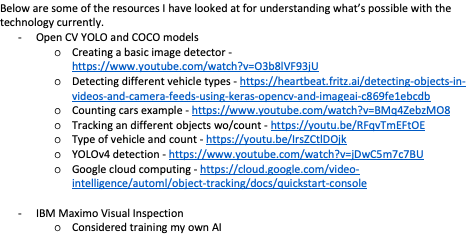

# YOLO DETECTION USING OPEN CV
https://www.youtube.com/watch?v=h56M5iUVgGs - italian guy
https://www.youtube.com/watch?v=IfRMV2MY9n0

IBM MODEL
https://developer.ibm.com/patterns/detect-track-and-count-cars-in-a-video/
    